# House prices - advanced regression techniques
With this dataset I will write different notebooks. This first one will be about data visualization, and I will use it to get familiar with using Python to this goal. It will be loosely based on this [tutorial on Kaggle](https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python/notebook) and this [other tutorial](https://www.kaggle.com/code/dgawlik/house-prices-eda). This is a big dataset in terms of reported variables, and it will provide some really great insights in how to visualize data.

Naming conventions will follow the tutorial out of ease, even though in my own style I prefer other naming of variables.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [8]:
df_train = pd.read_csv('../Datasets/Housing_prices/train.csv')
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### Missing data

<AxesSubplot:>

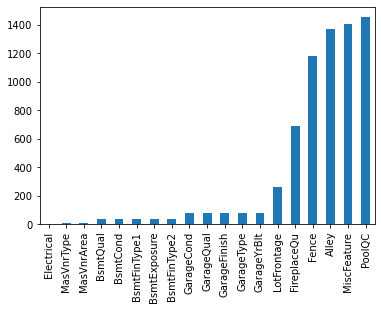

In [9]:
missing = df_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

There are missing data in 19 explanatory variables, and fortunately there are no missing data in the response variable.

### 'SalePrice' analysis
A good rule of thumb would be to start from an analysis of the response variable, that is the price at which we can sell the house. 

In [10]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

As a first observation, the range of prices does not touch upon zero, which is a good thing. This won't spoil a "normal" model by having to run shenanigans.

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

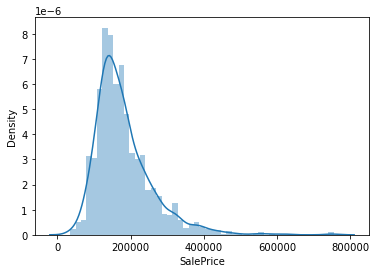

In [11]:
sns.distplot(df_train['SalePrice'])

This does not seem to be normally distributed, but what are skewness and kurtosis?

In [12]:
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


A bit unsurprisingly, the distribution of sale prices has positive skewness and excess kurtosis, meaning that we are with a fat-tailed distribution of sale prices.

## Explanatory variables

In [13]:
quantitative = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in df_train.columns if df_train.dtypes[f] == 'object']

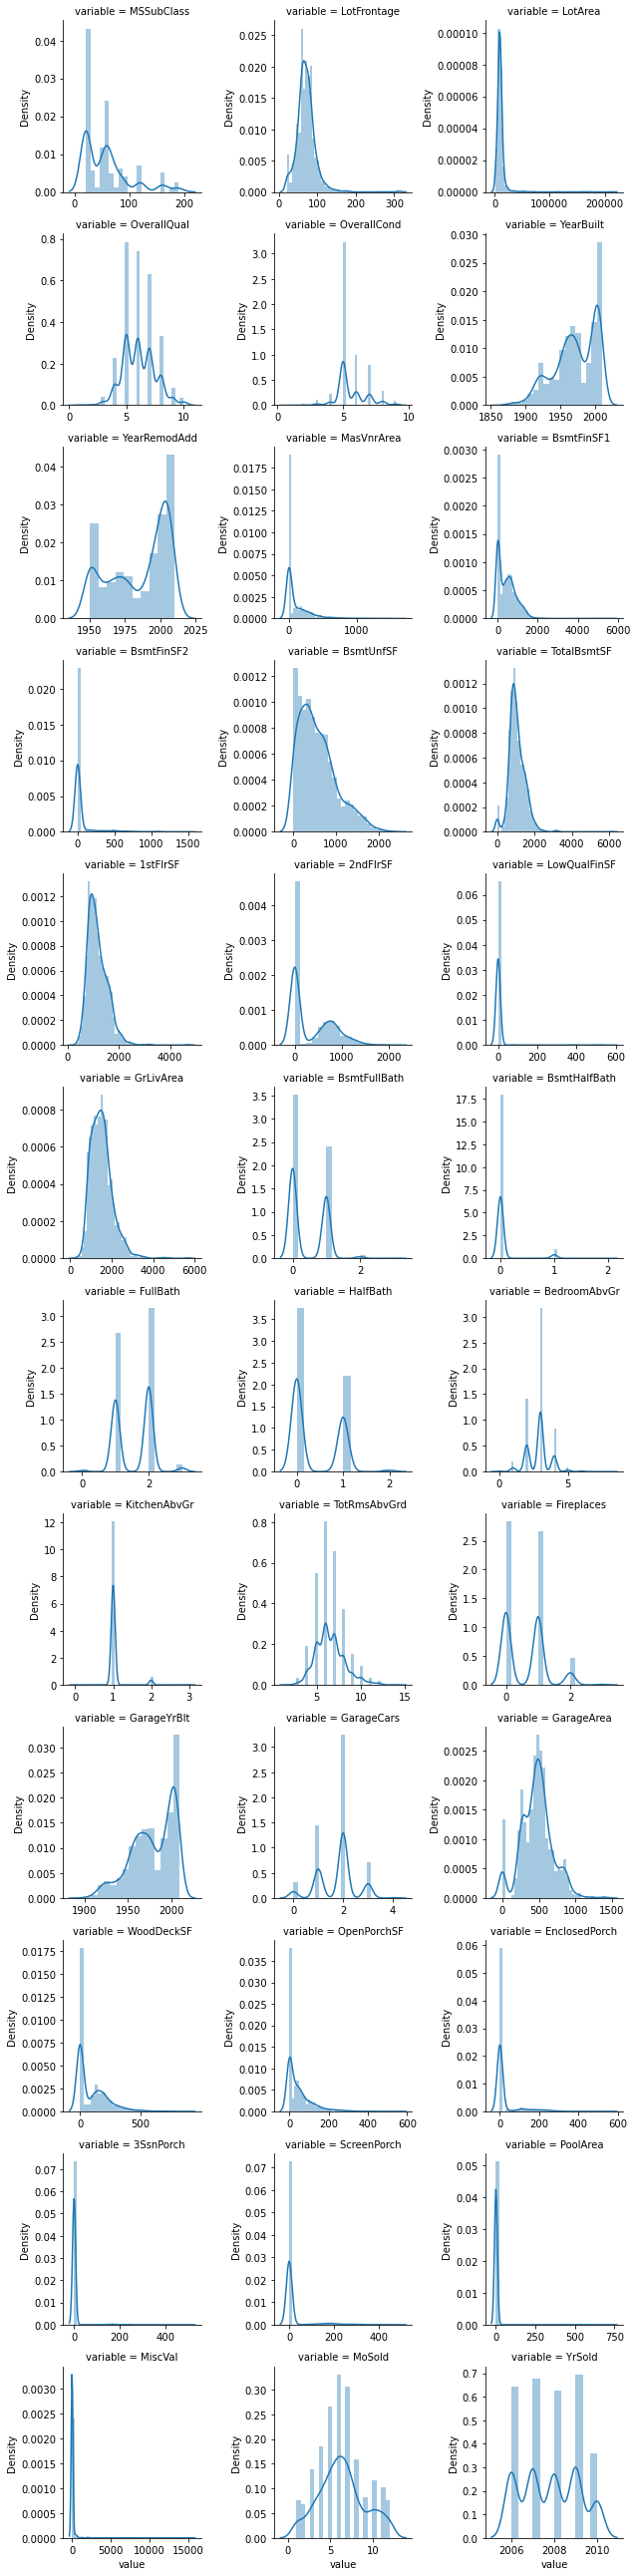

In [14]:
f = pd.melt(df_train, value_vars=quantitative)
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

Candidates for log transformation:
- LotFrontage
- LotArea
- TotalBsmtSF
- KitchenAbvGr
- ...

Irregularities, e.g. the large amount of houses with 0 in 2ndFlrSF could be candidates for feature construction.

In [15]:
for c in qualitative:
    df_train[c] = df_train[c].astype('category')
    if df_train[c].isnull().any():
        df_train[c] = df_train[c].cat.add_categories(['MISSING'])
        df_train[c] = df_train[c].fillna('MISSING')

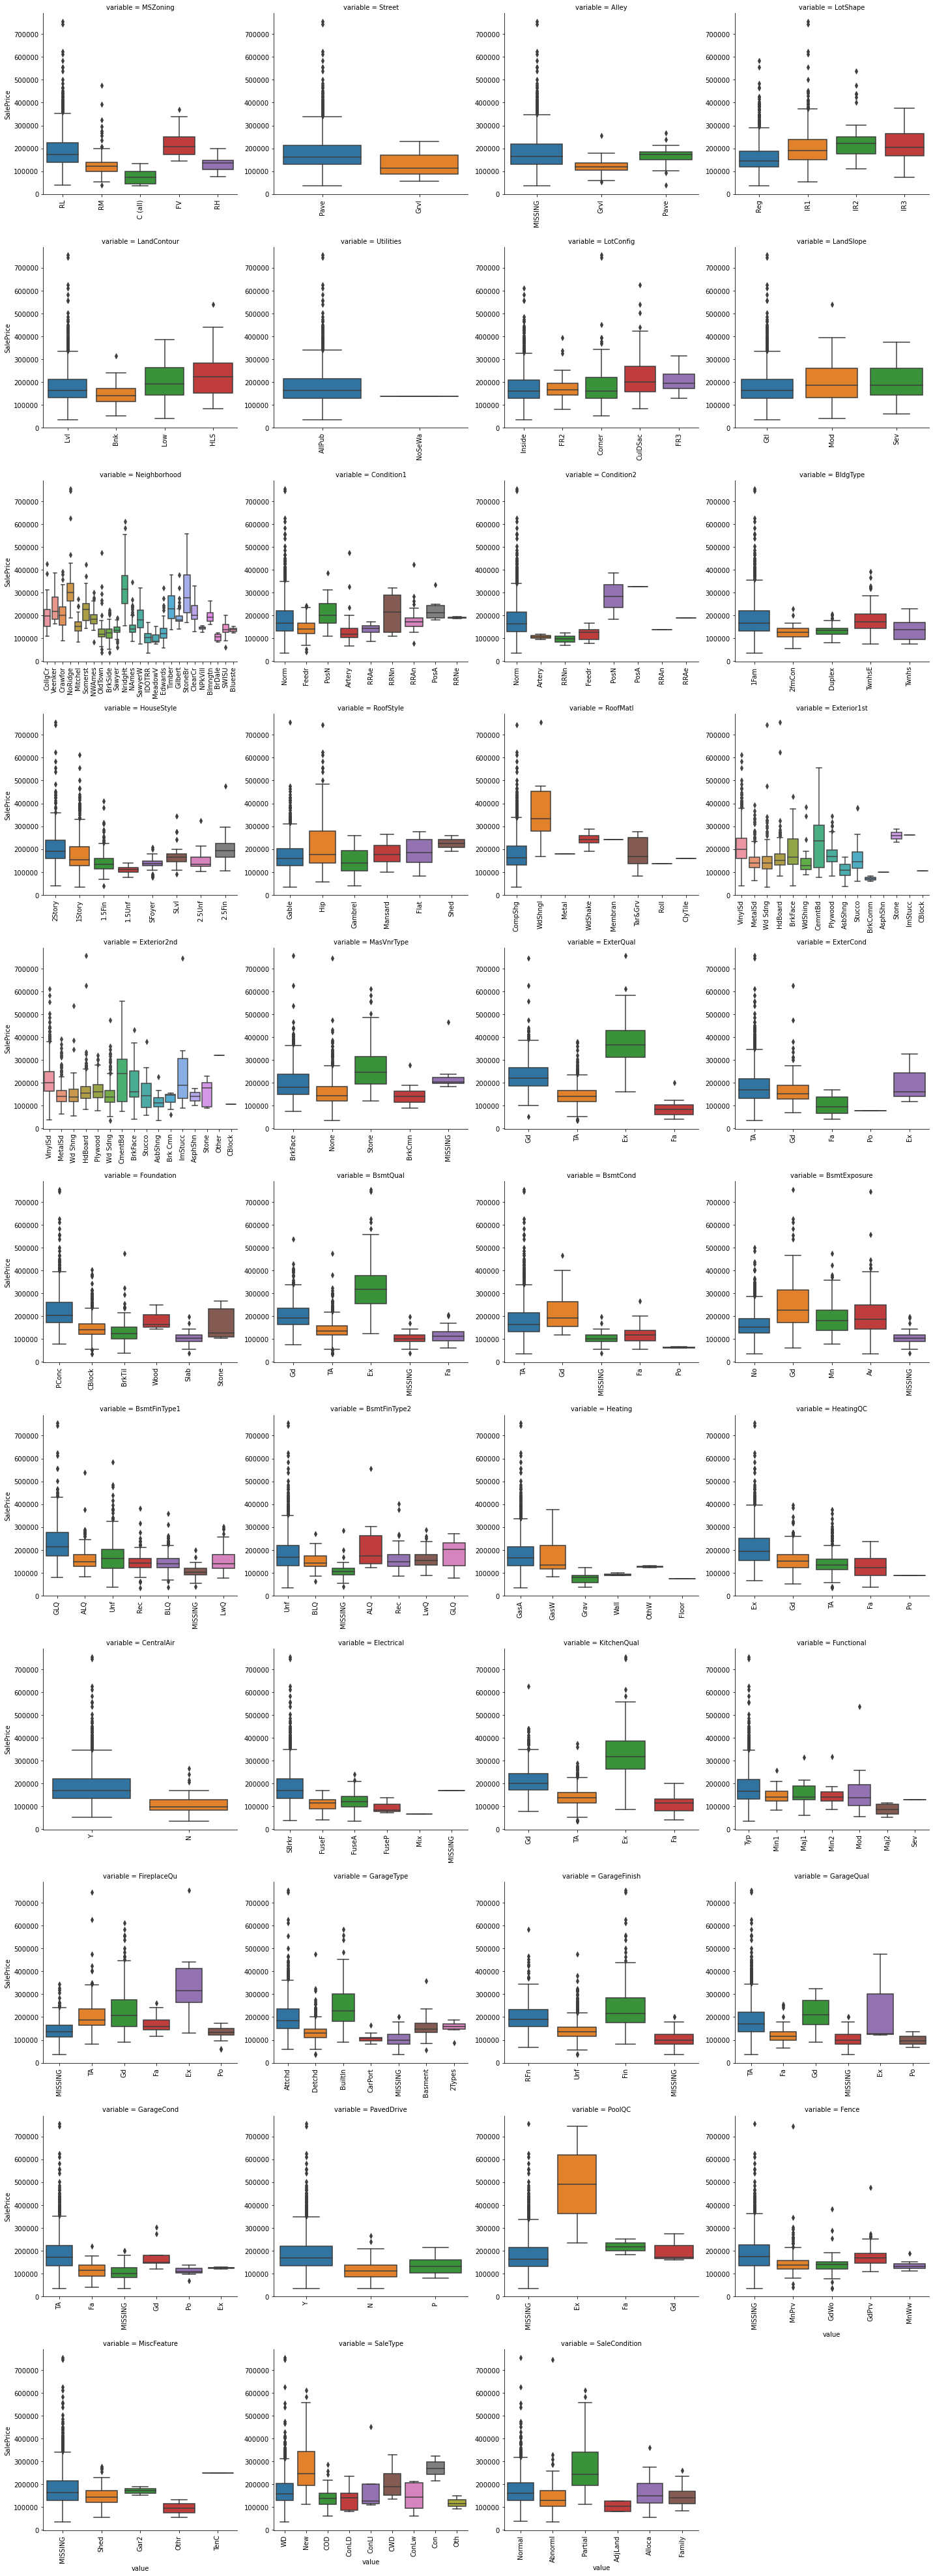

In [16]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x = plt.xticks(rotation=90)
f = pd.melt(df_train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

Let's write a function to run some anova:

In [17]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

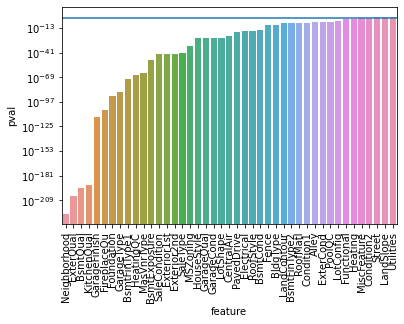

In [18]:
a = anova(df_train)
fig = sns.barplot(data=a, x='feature', y='pval')
fig.set_yscale('log')
fig.axhline(0.05)
x=plt.xticks(rotation=90)

Maybe analyzing p-values of Anova directly isn't cutting it well, but it's quite obvious that some variables matter more than other. Let us look at the disparity, defined as $\log(1/p_{val}$):

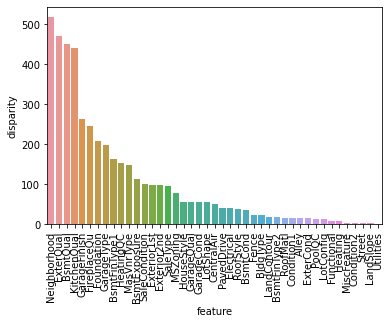

In [19]:
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x = plt.xticks(rotation=90)

Let's make some encoding here. Basically, we code each qualitative variable with numbers 1 to $n_{categories}$, ordered according to the 'SalePrice' mean of the variable. In short, if a variable has categories A, B and C, the three categories are coded to 1, 2, and 3, as: mean('SalePrice' | B) < mean('SalePrice' | C) < mean('SalePrice' | A). Then, B = 1, C = 2, A = 3 (in this example). 

This is important because otherwise correlations would make no sense, as encoding of variables right now is "nonsense": with a numerical encoding, the categorical variables are ordered.

In [23]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()

    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

To print out the names of encoded variables:

In [24]:
qual_encoded = []
for q in qualitative:
    encode(df_train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


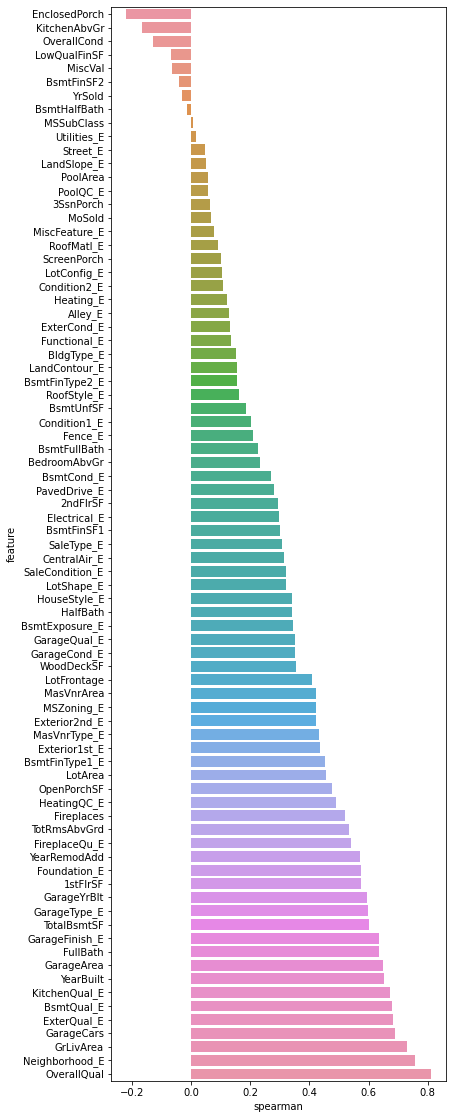

In [25]:
### Correlations

def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')

features = quantitative + qual_encoded
spearman(df_train, features)

'OverallQual' is then the most correlated variable with the response variable. 'Neighborhood' also has a strong effect, same as 'GrLivArea' (which represents the total living area above ground). If we look at the plot of OverallQual we can see that the correlation (on untransformed data) does not seem to be linear, but it's very obvious:

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

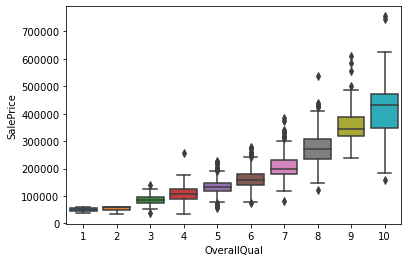

In [27]:
sns.boxplot(x='OverallQual', y='SalePrice', data=df_train)

Same goes if we plot neighborhood:

<AxesSubplot:xlabel='Neighborhood_E', ylabel='SalePrice'>

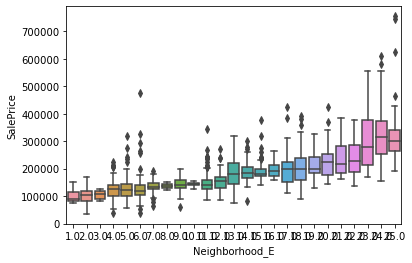

In [54]:
sns.boxplot(x='Neighborhood_E', y='SalePrice', data=df_train)

Indoubtedly there are also correlated variables, reason for which we might desire to apply a Lasso regression later on. Correlations might also be stronger for cheaper or more expensive houses. Let's see correlations by price segments, by checking differences in correlation between houses cheaper than 200'000 $ and houses more expensive.

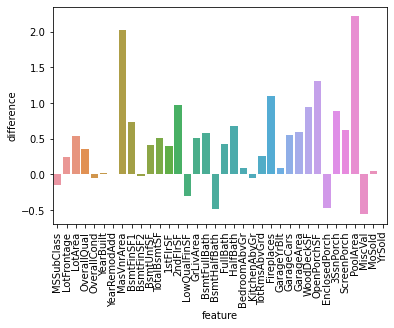

In [55]:
features = quantitative
standard = df_train[df_train['SalePrice'] < 200000]
pricey = df_train[df_train['SalePrice'] >= 200000]

diff = pd.DataFrame()
diff['feature'] = features
diff['difference'] = [(pricey[f].fillna(0.).mean() - standard[f].fillna(0.).mean())/(standard[f].fillna(0.).mean()) for f in features]
sns.barplot(data=diff, x='feature', y='difference')
x=plt.xticks(rotation=90)

Here, if differences are positive it means that the correlation between that variable and the sale price of the house is stronger for expensive houses. Indeed, we find that expensive houses have higher correlation with things such as presence of an open porch or pool area.